In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

In [2]:
train=pd.read_csv('train.csv',parse_dates=["datetime"])
train.shape

(10886, 12)

In [3]:
test=pd.read_csv('test.csv',parse_dates=["datetime"])
test.shape

(6493, 9)

In [11]:
train["year"]=train["datetime"].dt.year
train["month"]=train["datetime"].dt.month
train["hour"]=train["datetime"].dt.hour
train["dayofweek"]=train["datetime"].dt.dayofweek
train.shape

(10886, 17)

In [9]:
test["year"]=test["datetime"].dt.year
test["month"]=test["datetime"].dt.month
test["hour"]=test["datetime"].dt.hour
test["dayofweek"]=test["datetime"].dt.dayofweek
test.shape

(6493, 13)

In [12]:
#범주형을 category로
categorical_feature_names=["season","holiday","workingday","weather","dayofweek","month","year","hour"]
for var in categorical_feature_names:
    train[var]=train[var].astype("category")
    test[var]=test[var].astype("category")

feature_names=["season","weather","temp","atemp","humidity","holiday","workingday","dayofweek","year","hour"]
feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'holiday',
 'workingday',
 'dayofweek',
 'year',
 'hour']

In [14]:
x_train=train[feature_names]
print(x_train.shape)
x_train.head()

(10886, 10)


,season,weather,temp,atemp,humidity,holiday,workingday,dayofweek,year,hour
0,1,1,9.84,14.395,81,0,0,5,2011,0
1,1,1,9.02,13.635,80,0,0,5,2011,1
2,1,1,9.02,13.635,80,0,0,5,2011,2
3,1,1,9.84,14.395,75,0,0,5,2011,3
4,1,1,9.84,14.395,75,0,0,5,2011,4


In [15]:
x_test=train[feature_names]
print(x_test.shape)
x_test.head()

(10886, 10)


,season,weather,temp,atemp,humidity,holiday,workingday,dayofweek,year,hour
0,1,1,9.84,14.395,81,0,0,5,2011,0
1,1,1,9.02,13.635,80,0,0,5,2011,1
2,1,1,9.02,13.635,80,0,0,5,2011,2
3,1,1,9.84,14.395,75,0,0,5,2011,3
4,1,1,9.84,14.395,75,0,0,5,2011,4


In [16]:
label_name="count"
y_train=train[label_name]
print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [17]:
#RMSLE : 오차가 클수록 0에서 멀어진다. 
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    #넘파이로 배열 형태를 바꿔준다. 
    predicted_values=np.array(predicted_values)
    actual_values=np.array(actual_values)
    
    #예측갑솨 실제 값에 1을 더하고 로그를 씌워준다. 
    log_predict=np.log(predicted_values+1)
    log_actual=np.log(actual_values+1)
    
    #위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다. 
    difference=log_predict-log_actual
    difference=np.square(difference)
    
    #평균을 낸다
    mean_difference=difference.mean()
    
    #다시 루트를 씌운다
    score=np.sqrt(mean_difference)
    
    return score

rmsle_scorer=make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

In [22]:
from sklearn.linear_model import LinearRegression,Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment=None
warnings.filterwarnings("ignore",category=DeprecationWarning)

#선형회귀모델 초기화
lModel=LinearRegression()

#모델을 학습시킨다. 
y_train_log=np.log1p(y_train)
lModel.fit(x_train,y_train_log)

#예측하고 정확도를 평가한다
preds= lModel.predict(x_train)
print("RMS value for linear regression:",rmsle(np.exp(y_train_log),np.exp(preds)))

RMS value for linear regression: 0.9803697923313484


{'alpha': 0.1, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9803697718301236


AttributeError: 'GridSearchCV' object has no attribute 'grid'

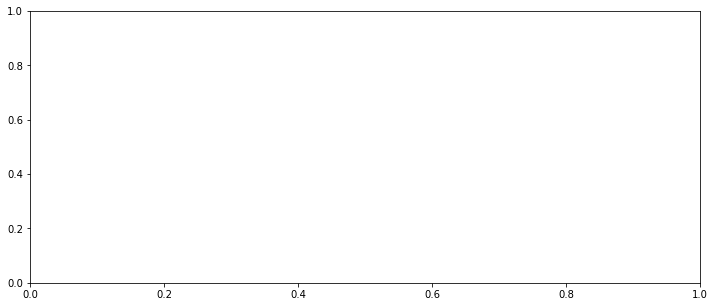

In [32]:
#릿지 모델 : 회귀를 위한 선형 모델, 가중치의 모든 원소를 0에 가깝게 만들어 기울기를 작게 만드는 모델 
#규제: 오버피팅이 되지 않도록 모델을 강제한다. 
#max_iter 3000까지만
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV(ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)
y_train_log= np.log1p(y_train)
grid_ridge_m.fit(x_train, y_train_log)
preds = grid_ridge_m.predict(x_train)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ",rmsle(np.exp(y_train_log),np.exp(preds)))

fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_ridge_m.grid.score)
df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)
plt.xticks(rotation=30,ha='right')
sns.poinplot(data=df,x='alpha',y='rmsle',ax=ax)